# PyTorch TensorBoard Support

## Introduction

Training variant of LeNet-5 against Fashion-MNIST dataset.

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter


## Showing Images in TensorBoard

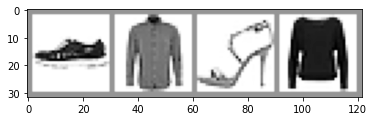

In [17]:
# Gather datasets and prepare for consumption
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Store separate training and validation splits in ./data
train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, train=True, transform=transform
)
validation_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, train=False, transform=transform
)

training_loader = torch.utils.data.DataLoader(
    train_set, batch_size=4, shuffle=True, num_workers=2
)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False, num_workers=2
)

# Class labels
classes = (
    "T-shirt/top",
    "Trousers",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

# Helper func for inline image display
def mpl_imshow(img, one_channel=False):

    if one_channel:
        img = img.mean(dim=0)

    img = img / 2 + 0.5  # un-normalise

    npimg = img.numpy()

    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract bath of 4 imgs
dataiter = iter(training_loader)
imgs, labels = dataiter.next()

# Create grid from images and show them
img_grid = torchvision.utils.make_grid(imgs)
mpl_imshow(img_grid, one_channel=True)


In [13]:
# Use add_image() on SummaryWriter to log image for consumption by TensorBoard
# Call flush() to make sure it's written to disc immediately

writer = SummaryWriter("runs/fashion_mnist_experiment_1")

# Write img data to TensorBoard log dir
writer.add_image("Four Fashion-MNIST Images", img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/
# Or (try to) start VS Code TensorBoard session

## Graphing Scalars to Visualise Training

In [18]:
# Define model, optimiser, and loss function

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
# Train epoch, evaluate training vs validation set losses every 1000 batches

print(len(validation_loader))
for epoch in range(1):
    running_loss = 0.0

    for i, data in enumerate(training_loader):
        # Basic training loop
        inputs, labels = data
        optimiser.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        if i % 1000 == 999:  # every 1000 mini-batches
            print("Batch", i+1)
            running_vloss = 0.0  # check against validation set

            net.train(False)  # no need to track grads for validation
            for j, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True)  # turn grads back on for training

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            writer.add_scalars("Training vs Validation Loss",
                              {"Training": avg_loss, "Validation": avg_vloss},
                              epoch * len(training_loader) + i)

            running_loss = 0.0
    
print("Finished Training")

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


## Visualing Your Model

In [20]:
# Grab single mini-batch of images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# Trace sample input through model and render as graph
writer.add_graph(net, images)

writer.flush()

## Visualising Your Dataset with Embeddings

It can be instructive to project high-dim vectors into lower-dim representations. `add_embedding()`  will project set of data onto the three dimensions with highest variance, display them as interactive 3D chart.

In [27]:
# Select random data subset and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]


# Extract random data subset
images, labels = select_n_random(train_set.data, train_set.targets)

# Get the class labels for each image
class_labels = [classes[label] for label in labels]

# Log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))

writer.flush()
writer.close()